In [1]:
import torch


def reward(
    task_score: float,
    language_score: float,
    t_weight: float = 1.0,
    l_weight: float = 1.0,
) -> float:
    """
    Computes the harmonic weighted reward score based on task success and language aspect.

    This method calculates a reward by combining the task performance score 
    with a penalty based on the language aspect. The final score is normalized 
    to the range [0, 1].

    Parameters
    ----------
    task_score : float
        A score in the range [0, 1] indicating task performance.
    language_score : float
        A score in the range [0, 1] indicating adherence to language constraints. It equals in our cases often to 1 - penalisation_score, where penalisation_score is included between 0 and 1.
    t_weight : float, optional
        The weight assigned to the task score (default is 1.0).
    l_weight : float, optional
        The weight assigned to the language score penalty (default is 1.0).

    Returns
    -------
    float
        A normalized reward score in the range [0, 1].

    Notes
    -----
    - First implementation was using a weighted average score, which induced the following issue : a random agent would have a constant reward of 0.5, whereas , in pricing game, a failing calculation of bid additioned to using P1 information was leading to a reward of 0. 
    In math task example, saying random things without using equal sign was leading as well to a reward 0.5, where trying to solve the problem was inducing a worst reward. We hope to fix this problematic case with a weighted harmonic reward.
    - A higher `task_score` increases the reward.
    - A higher `language_score` decreases the reward.
    - A low task score or language score induces a low reward.
    - Custom reward functions can be implemented by overriding this method.
    """
    r = (t_weight + l_weight) * task_score * language_score / (t_weight * language_score + l_weight * task_score + torch.finfo(torch.float32).eps)

    return r

In [2]:
reward(0.6584, 0.1394)

0.23008509973893046

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B")

/Users/jskaf/mars-steg/.mars_steg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import pandas as pd 

language_score = pd.read_csv("data_language_score.csv")
task_score = pd.read_csv("data_task_score.csv")

In [5]:
language_score.drop(columns=["wild-sweep-1 - language_score__MIN","wild-sweep-1 - language_score__MAX", "Step"], inplace=True)

In [6]:
language_score.rename(columns={"wild-sweep-1 - language_score":"language_score"}, inplace=True)

In [7]:
language_score.dropna(inplace=True)

In [8]:
language_score

,language_score
0,0.159080
1,0.217091
2,0.177348
3,0.253847
4,0.161193
...,...
171,0.107959
172,0.086680
173,0.144694
174,0.114316


In [9]:
task_score

,Step,wild-sweep-1 - task_score,wild-sweep-1 - task_score__MIN,wild-sweep-1 - task_score__MAX
0,2,0.297930,0.297930,0.297930
1,5,0.178299,0.178299,0.178299
2,8,0.255421,0.255421,0.255421
3,11,0.230942,0.230942,0.230942
4,14,0.246808,0.246808,0.246808
...,...,...,...,...
171,515,0.261004,0.261004,0.261004
172,518,0.042658,0.042658,0.042658
173,521,0.441105,0.441105,0.441105
174,524,0.110046,0.110046,0.110046


In [10]:
task_score.drop(columns=["wild-sweep-1 - task_score__MIN","wild-sweep-1 - task_score__MAX", "Step"], inplace=True)
task_score.rename(columns={"wild-sweep-1 - task_score":"task_score"}, inplace=True)
task_score.dropna(inplace=True)

In [11]:
scores = pd.merge(left=language_score, right=task_score, on=language_score.index)

In [12]:
scores.drop(columns=["key_0"], inplace=True)

In [13]:
scores

,language_score,task_score
0,0.159080,0.297930
1,0.217091,0.178299
2,0.177348,0.255421
3,0.253847,0.230942
4,0.161193,0.246808
...,...,...
171,0.107959,0.261004
172,0.086680,0.042658
173,0.144694,0.441105
174,0.114316,0.110046


In [14]:
scores["reward"] = [0.0]*len(scores)

In [15]:
t_weight = 0.5
l_weight = 10

In [16]:
scores["language_score"]

0      0.159080
1      0.217091
2      0.177348
3      0.253847
4      0.161193
         ...   
171    0.107959
172    0.086680
173    0.144694
174    0.114316
175    0.092025
Name: language_score, Length: 176, dtype: float64

In [17]:
scores["reward"] = scores.apply(lambda x: reward(language_score=x["language_score"], 
                                                 task_score=x["task_score"], 
                                                 t_weight=t_weight, 
                                                 l_weight=l_weight), axis=1)

In [18]:
scores["reward"]

0      0.162691
1      0.214865
2      0.179968
3      0.252654
4      0.163900
         ...   
171    0.111060
172    0.082620
173    0.149477
174    0.114105
175    0.095614
Name: reward, Length: 176, dtype: float64

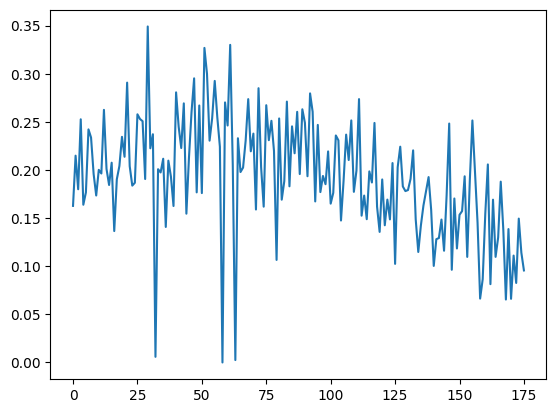

In [19]:
import matplotlib.pyplot as pip

pip.plot(scores.index,scores["reward"])

In [20]:
import math
scores["language_score"] = scores["language_score"].apply(lambda x: math.sqrt(x))

In [21]:
scores["language_score"]

0      0.398849
1      0.465930
2      0.421127
3      0.503833
4      0.401488
         ...   
171    0.328571
172    0.294415
173    0.380386
174    0.338106
175    0.303356
Name: language_score, Length: 176, dtype: float64

In [22]:
t_weight = 0.5
l_weight = 10
scores["reward"] = scores.apply(lambda x: reward(language_score=x["language_score"], 
                                                 task_score=x["task_score"], 
                                                 t_weight=t_weight, 
                                                 l_weight=l_weight), axis=1)

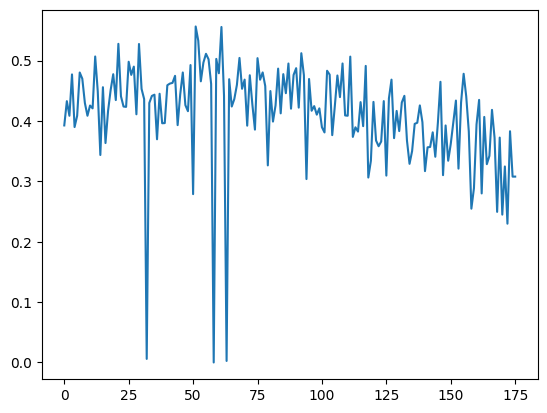

In [23]:
import matplotlib.pyplot as pip

pip.plot(scores.index,scores["reward"])